In [18]:
#import all modules used in this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import statistics
import time

from sklearnex import patch_sklearn
patch_sklearn('SVC')

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
#define shared functions used in this notebook

#seperates data into X and y
#preprocess data with one hot encoding and standard scaling
def getEncodedData(df):

    X = df.drop(columns=['y'])
    y = df['y']
    
    cat_features = X.select_dtypes(include='object').columns
    num_features = X.select_dtypes(include='number').columns
    
    preprocessor = ColumnTransformer(transformers=[ 
        ('cat', OneHotEncoder(sparse_output=False, drop='if_binary'), cat_features),
        ('num', StandardScaler(), num_features)                                                       
    ]).set_output(transform='pandas')
    
    return preprocessor.fit_transform(X), y

#run models with default hyperparameters and return statistics about results
def runModels(X_train, X_test, y_train, y_test):

    models = [LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), svm.SVC()]
    
    model_names = ['LogisticRegression', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVC']
    
    results = None
    
    for index, model in enumerate(models):
    
        start = time.process_time()
        model.fit(X_train, y_train)
        end = time.process_time()
        
        train_time = round(end - start, 2)
        train_accuracy = round(model.score(X_train, y_train), 2)
        test_accuracy = round(model.score(X_test, y_test), 2)
        train_recall = round(recall_score(model.predict(X_train), y_train, pos_label='yes'), 2)
        test_recall = round(recall_score(model.predict(X_test), y_test, pos_label='yes'), 2)
        
        row = pd.DataFrame(
            [[model_names[index], train_time, train_accuracy, test_accuracy, train_recall, test_recall]],
            columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Train Recall', 'Test Recall']
        ).set_index('Model')
    
        if results is None:
    
            results = row
    
        else:
        
            results = pd.concat([results, row])
    
    return results

#visualize features for exploration using histogram and bar plots
def visualize_features(feature_names):

    cat_features = df.select_dtypes(include='object').columns
    num_features = df.select_dtypes(include='number').columns

    for feature_name in feature_names:

        series = df[feature_name]

        if feature_name in cat_features:
            value_counts = series.value_counts()
            if len(value_counts) < 100:
                title = '\'' + feature_name + '\' value counts'
                plt.figure(figsize=(14,3))
                ax = sns.barplot(value_counts)
                ax.set_title(title)
                ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
                plt.show()
    
        if feature_name in num_features:
            title = '\'' + feature_name + '\' value counts'
            plt.figure(figsize=(14,3))
            ax = sns.histplot(series)
            ax.set_title(title)
            if feature_name in ['duration']:
                ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            plt.show()

#returns outliers of the series using the IQR method
def get_outliers_iqr(column):

    outliers = []
    sorted_column = sorted(column)
    q1 = np.percentile(sorted_column, 25)
    q3 = np.percentile(sorted_column, 75)
    
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)

    condition = (column > lwr_bound) & (column < upr_bound)
    
    return condition

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

- This data represents 17 campaigns that occurred between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



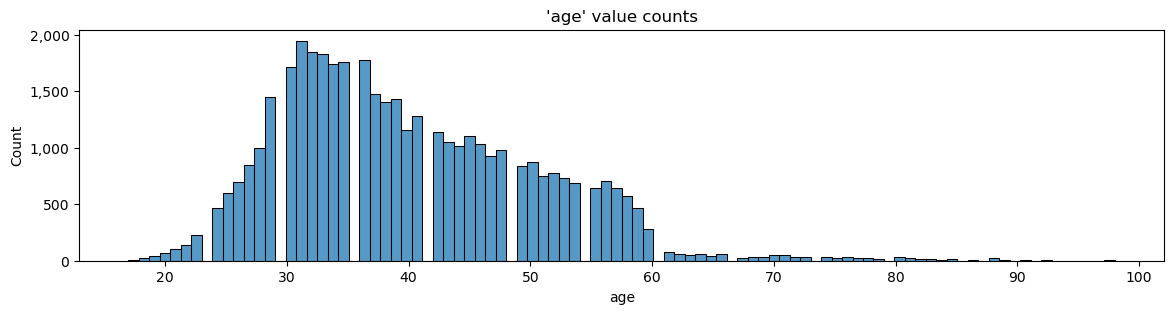

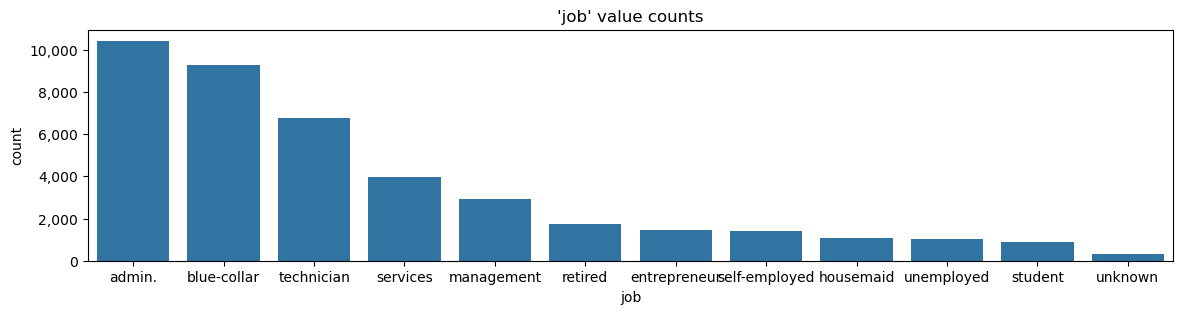

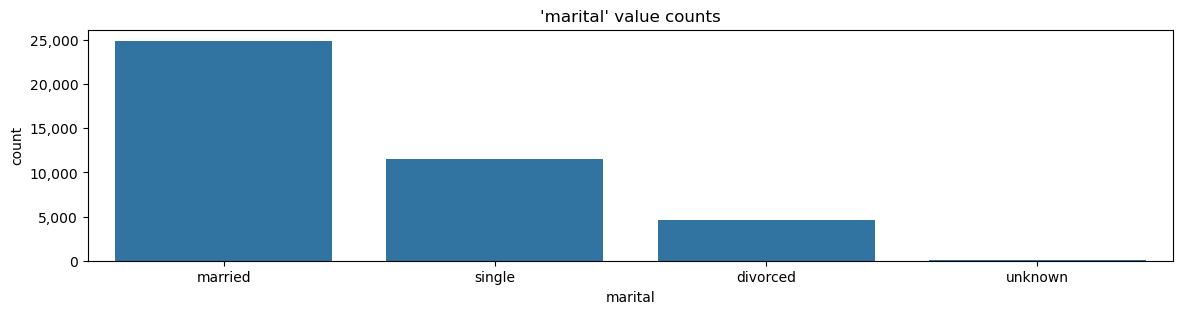

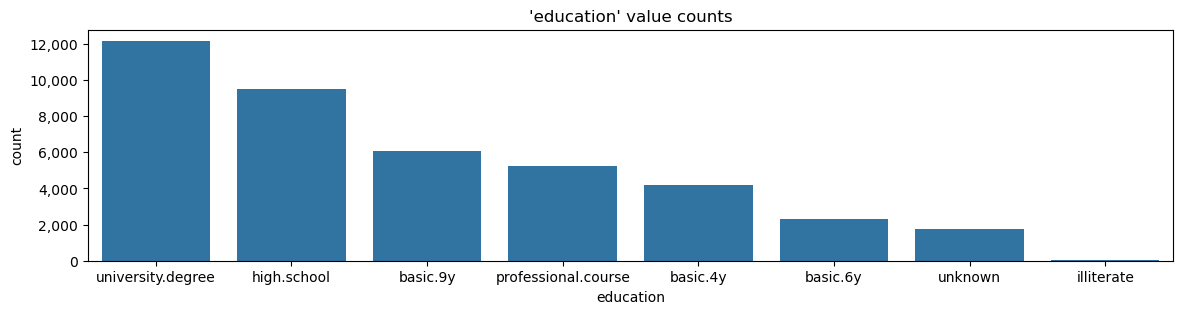

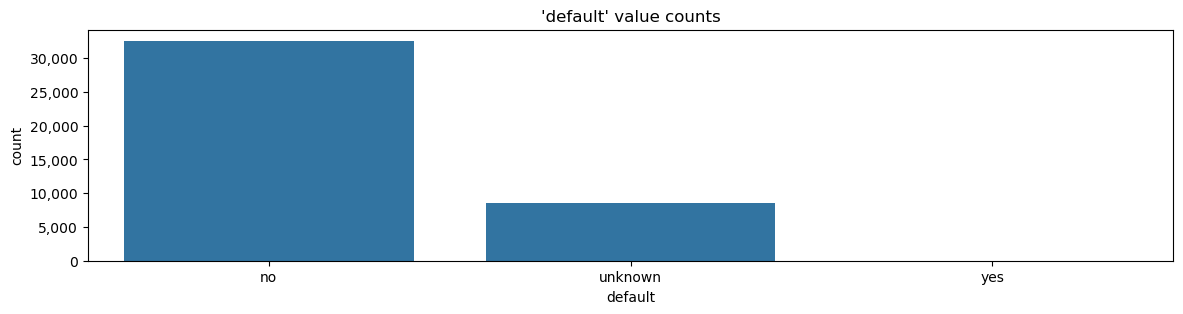

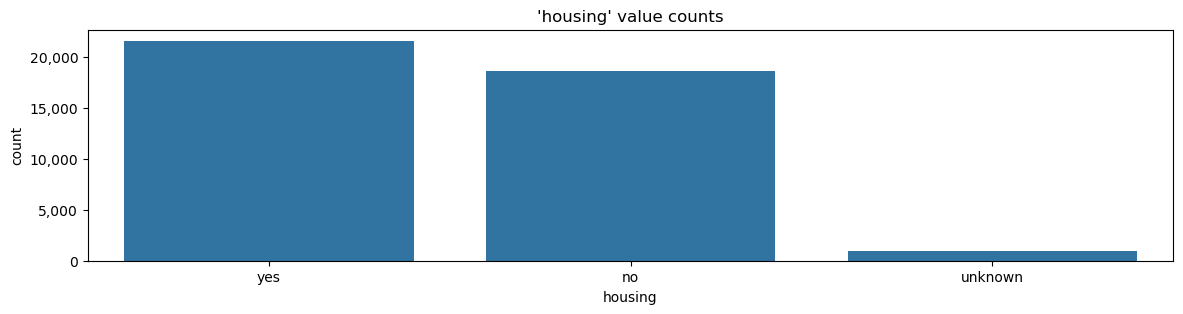

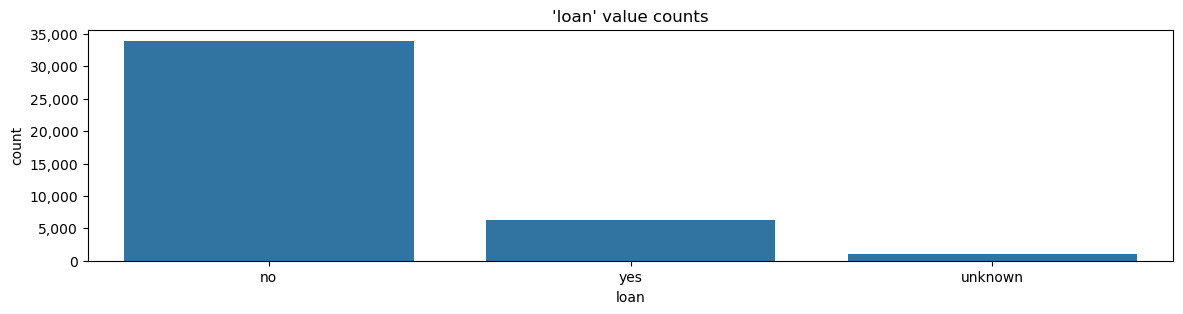

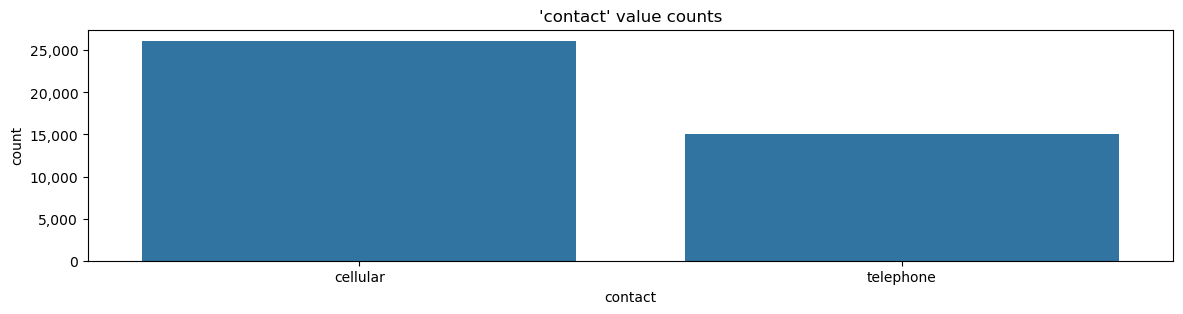

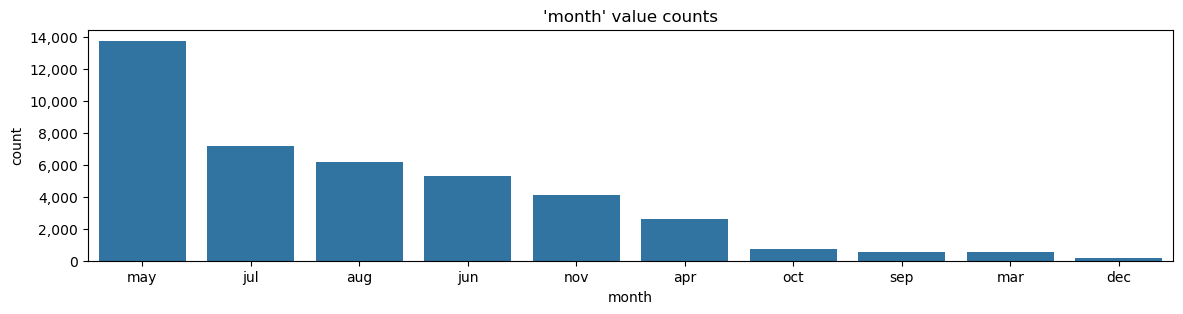

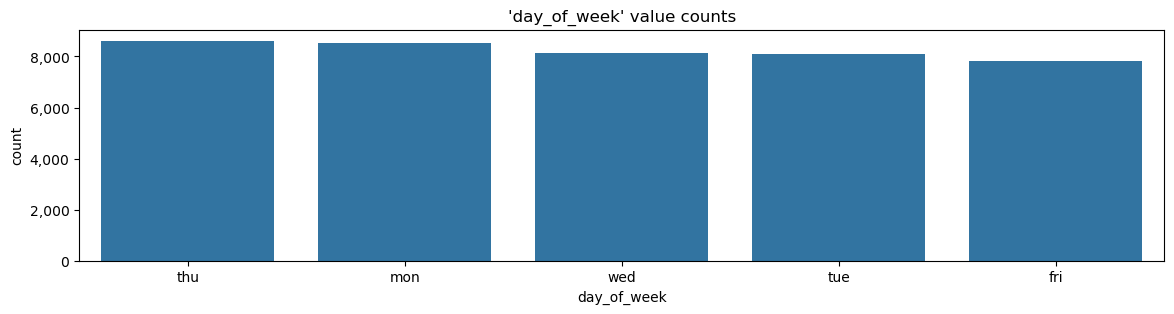

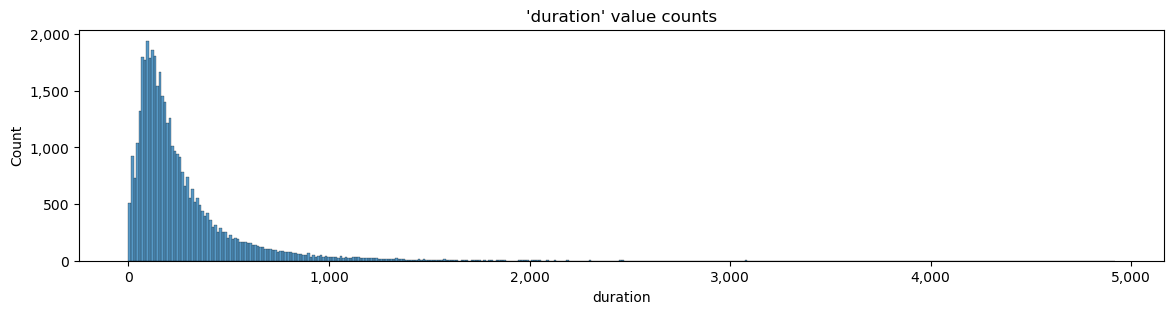

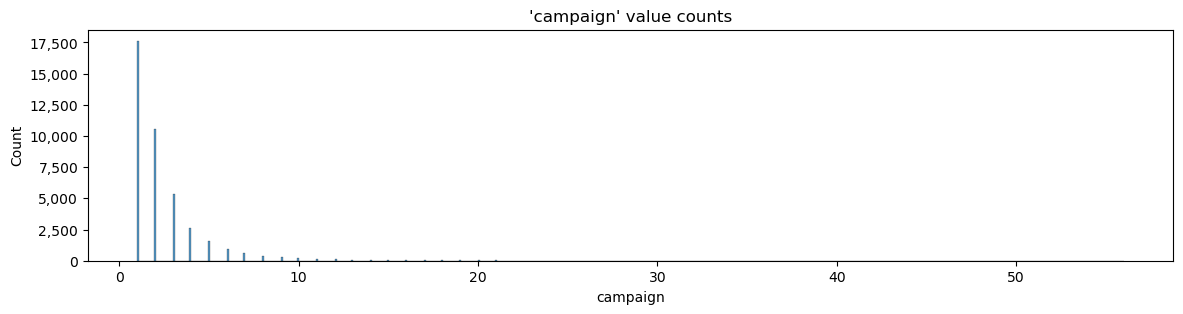

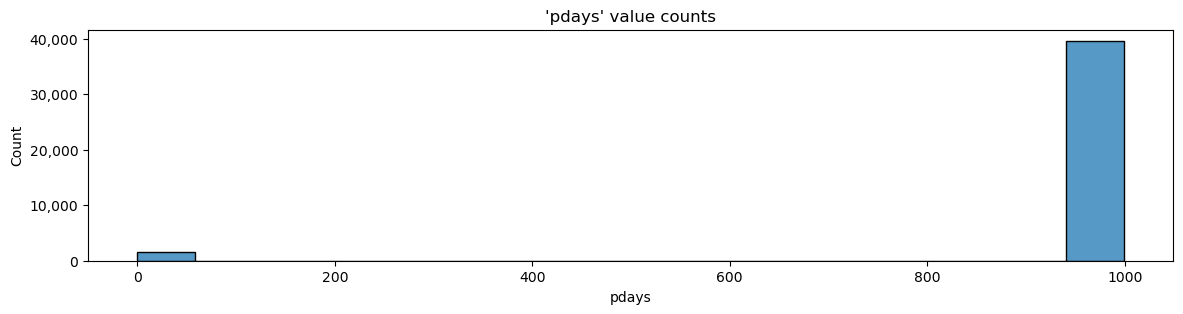

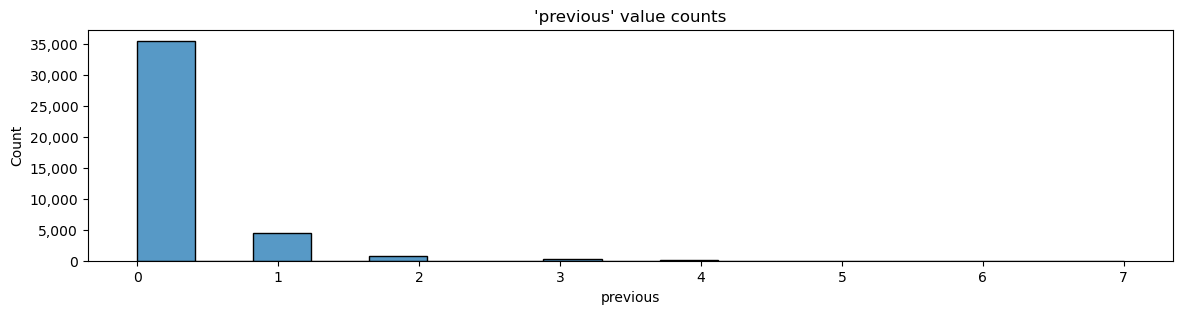

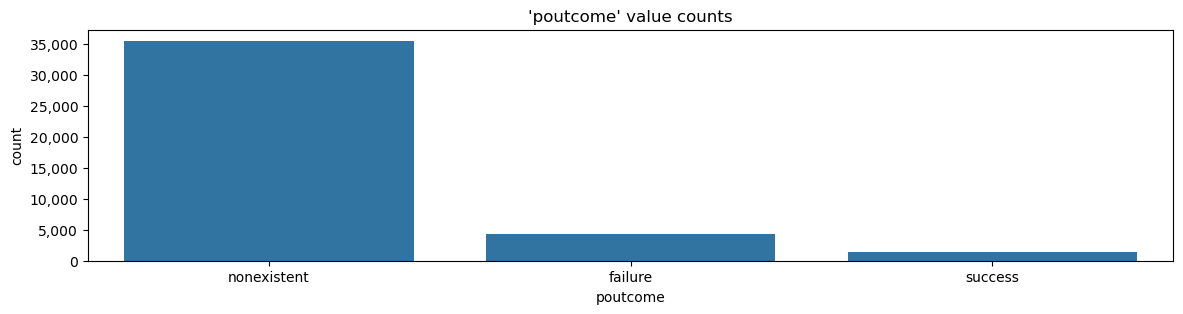

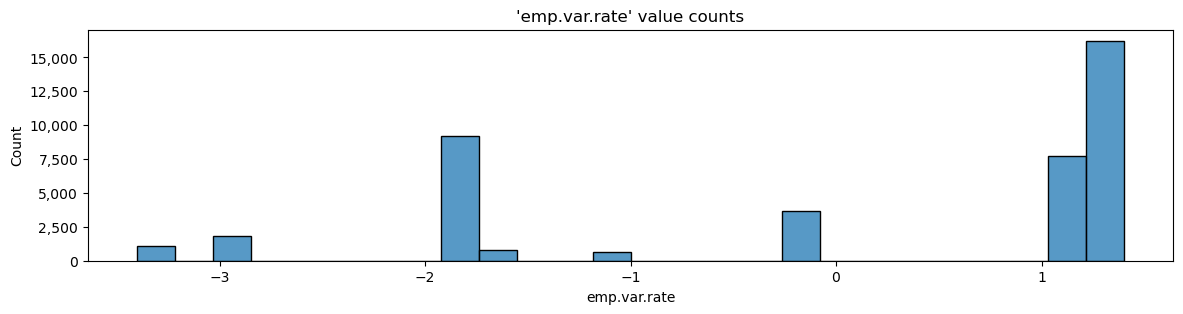

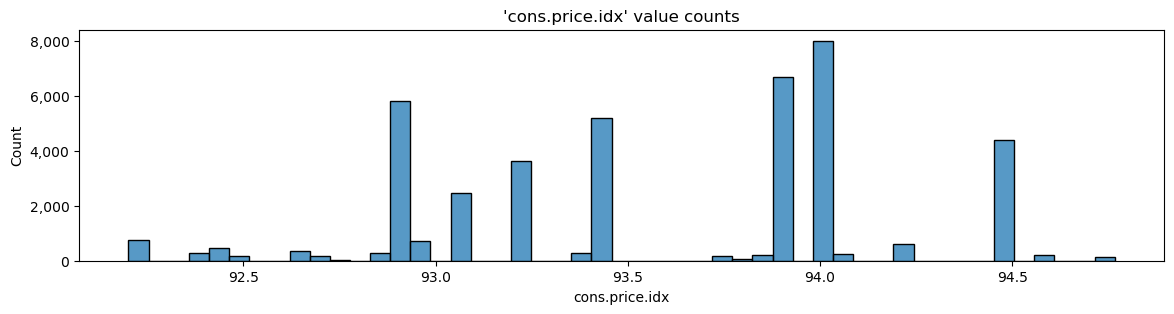

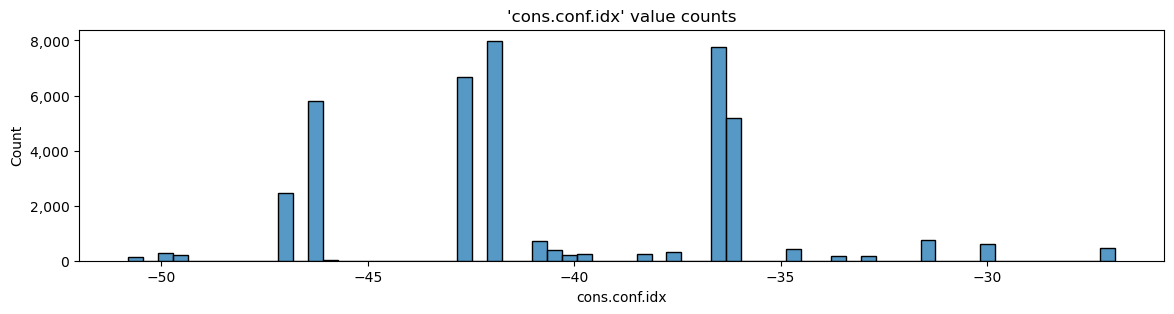

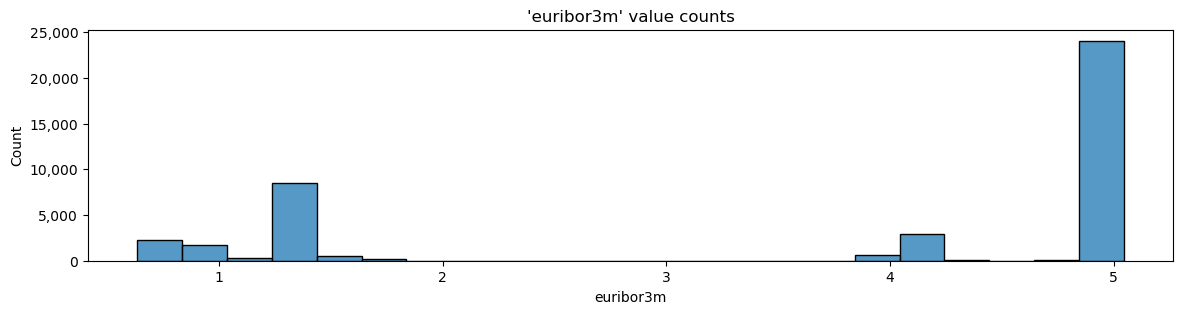

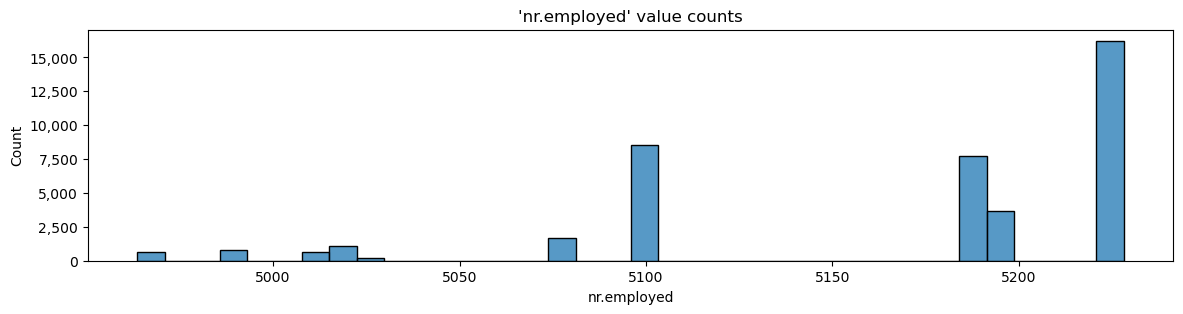

In [5]:
features = df.columns.drop('y')

visualize_features(features)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

- Using the features of the data, we will build models that can predict whether a customer subscribes to a term deposit or not.
- Once we have a model we are happy with, we will investigate the importance of the features to gain insight into what features are most important when it comes to getting the cusotmer to subscribe.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
X, y = getEncodedData(df)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [8]:
model = DummyClassifier().fit(X_train, y_train)
print('Model accuracy:', round(model.score(X_test, y_test), 2))

Model accuracy: 0.89


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [9]:
model = LogisticRegression().fit(X_train, y_train)

### Problem 9: Score the Model

What is the accuracy of your model?

In [10]:
print('Model accuracy:', round(model.score(X_test, y_test), 2))

Model accuracy: 0.91


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [11]:
print('Default models on original set:')
runModels(X_train, X_test, y_train, y_test)

Default models on original set:


,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall
Model,,,,,
LogisticRegression,1.22,0.91,0.91,0.67,0.65
DecisionTreeClassifier,0.30,1.00,0.89,1.00,0.53
KNeighborsClassifier,0.04,0.93,0.90,0.75,0.59
SVC,6.91,0.92,0.91,0.76,0.65


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### 11a. Remove outliers from dataset and run default models

In [12]:
#remove outliers from chosen numerical columns using iqr method
#train models with filtered train set and compare with previous results

columns = list(df.select_dtypes(include='number').columns)
columns.remove('pdays')
columns.remove('previous')

condition = np.full(df.shape[0], True)
for series_name, series in df[columns].items():
    condition = condition & get_outliers_iqr(series)

df_filtered = df[condition]

X_filtered, y_filtered = getEncodedData(df_filtered)

X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test = train_test_split(X_filtered, y_filtered)

print('Default models on filtered set:')
runModels(X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test)

Default models on filtered set:


,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall
Model,,,,,
LogisticRegression,0.84,0.94,0.94,0.67,0.68
DecisionTreeClassifier,0.27,1.00,0.91,1.00,0.45
KNeighborsClassifier,0.03,0.95,0.93,0.76,0.58
SVC,4.77,0.95,0.94,0.80,0.69


### 11b. Grid search SVC

In [13]:
#Grid search SVC for optimal C parameter

params = {'C' : [1.0, 10.0, 100.0, 500.0, 1000.0]}

custom_scorer = make_scorer(recall_score, pos_label='yes')

gs = GridSearchCV(
    svm.SVC(),
    param_grid = params,
    scoring = custom_scorer,
    n_jobs = -1,
).fit(X_filtered_train, y_filtered_train)

print('Grid Search Results:')
cv_results = pd.DataFrame.from_dict(gs.cv_results_)
cv_results[['params', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score']).head()

Grid Search Results:


,params,mean_test_score,rank_test_score
4,{'C': 1000.0},0.486420,1
3,{'C': 500.0},0.484444,2
2,{'C': 100.0},0.481975,3
1,{'C': 10.0},0.440000,4
0,{'C': 1.0},0.383704,5


### Analysis:
The results of the grid search suggest that the higher the C value, the higher the recall score will be. However, it is worth noting that the increase in recall score becomes very small with higher C values. As increasing the C value causes a significant increase in model train time, we should aim to find a nice balance between train time and recall score.

### 11c. Investigate results of SVC

In [14]:
models = [svm.SVC(C=1), svm.SVC(C=10), svm.SVC(C=100), svm.SVC(C=1000)]
    
model_names = ['SVC, C=1', 'SVC, C=10', 'SVC, C=100', 'SVC, C=1000']

results = None

for index, model in enumerate(models):

    start = time.process_time()
    model.fit(X_filtered_train, y_filtered_train)
    end = time.process_time()
    
    train_time = round(end - start, 2)
    train_accuracy = round(model.score(X_filtered_train, y_filtered_train), 2)
    test_accuracy = round(model.score(X_filtered_test, y_filtered_test), 2)
    train_recall = round(recall_score(model.predict(X_filtered_train), y_filtered_train, pos_label='yes'), 2)
    test_recall = round(recall_score(model.predict(X_filtered_test), y_filtered_test, pos_label='yes'), 2)
    
    row = pd.DataFrame(
        [[model_names[index], train_time, train_accuracy, test_accuracy, train_recall, test_recall]],
        columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Train Recall', 'Test Recall']
    ).set_index('Model')

    if results is None:

        results = row

    else:
    
        results = pd.concat([results, row])

results

,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall
Model,,,,,
"SVC, C=1",4.58,0.95,0.94,0.80,0.69
"SVC, C=10",9.56,0.97,0.93,0.93,0.59
"SVC, C=100",42.12,0.99,0.92,0.99,0.46
"SVC, C=1000",65.79,1.00,0.91,1.00,0.44


### Analysis:
It appears that increasing the C value of the SVC model causes the Test Recall to decrease, which we definitely do not want.

### 11d. Grid search LogisticRegression

In [15]:
#Grid search LogisticRegression for optimal C

params = {'C' : np.logspace(-3,3,7)}

custom_scorer = make_scorer(recall_score, pos_label='yes')

gs = GridSearchCV(
    LogisticRegression(),
    param_grid = params,
    scoring = custom_scorer,
    n_jobs = -1,
).fit(X_filtered_train, y_filtered_train)

test_recall = round(recall_score(gs.predict(X_filtered_test), y_filtered_test, pos_label='yes'), 2)
print('Grid Search Best Test Recall:', test_recall)

print('Grid Search Results:')
cv_results = pd.DataFrame.from_dict(gs.cv_results_)
cv_results[['params', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score']).head()

Grid Search Best Test Recall: 0.68
Grid Search Results:


,params,mean_test_score,rank_test_score
5,{'C': 100.0},0.420247,1
6,{'C': 1000.0},0.417778,2
3,{'C': 1.0},0.417284,3
4,{'C': 10.0},0.417284,3
2,{'C': 0.1},0.409877,5


### Analysis:
It appears that tuning the C parameter of LogisticRegression does not increase the Recall score.

### 11e. Grid search KNeighborsClassifier

In [16]:
#Grid search KNeighborsClassifier

params = { 'n_neighbors' : range(1,30)}

custom_scorer = make_scorer(recall_score, pos_label='yes')

gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid = params,
    scoring = custom_scorer,
    n_jobs = -1,
).fit(X_filtered_train, y_filtered_train)

print('Grid Search Results:')
cv_results = pd.DataFrame.from_dict(gs.cv_results_)
cv_results[['params', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score']).head()

Grid Search Results:


,params,mean_test_score,rank_test_score
0,{'n_neighbors': 1},0.433580,1
2,{'n_neighbors': 3},0.405926,2
4,{'n_neighbors': 5},0.405432,3
6,{'n_neighbors': 7},0.393580,4
8,{'n_neighbors': 9},0.388148,5


### Analysis:
It appears that no further optimization is possible with the KNeighborsClassifier model.

### Summary:
The model that gave us the best recall score is SVC() with default hyperparameters.
### Investigate feature importance:

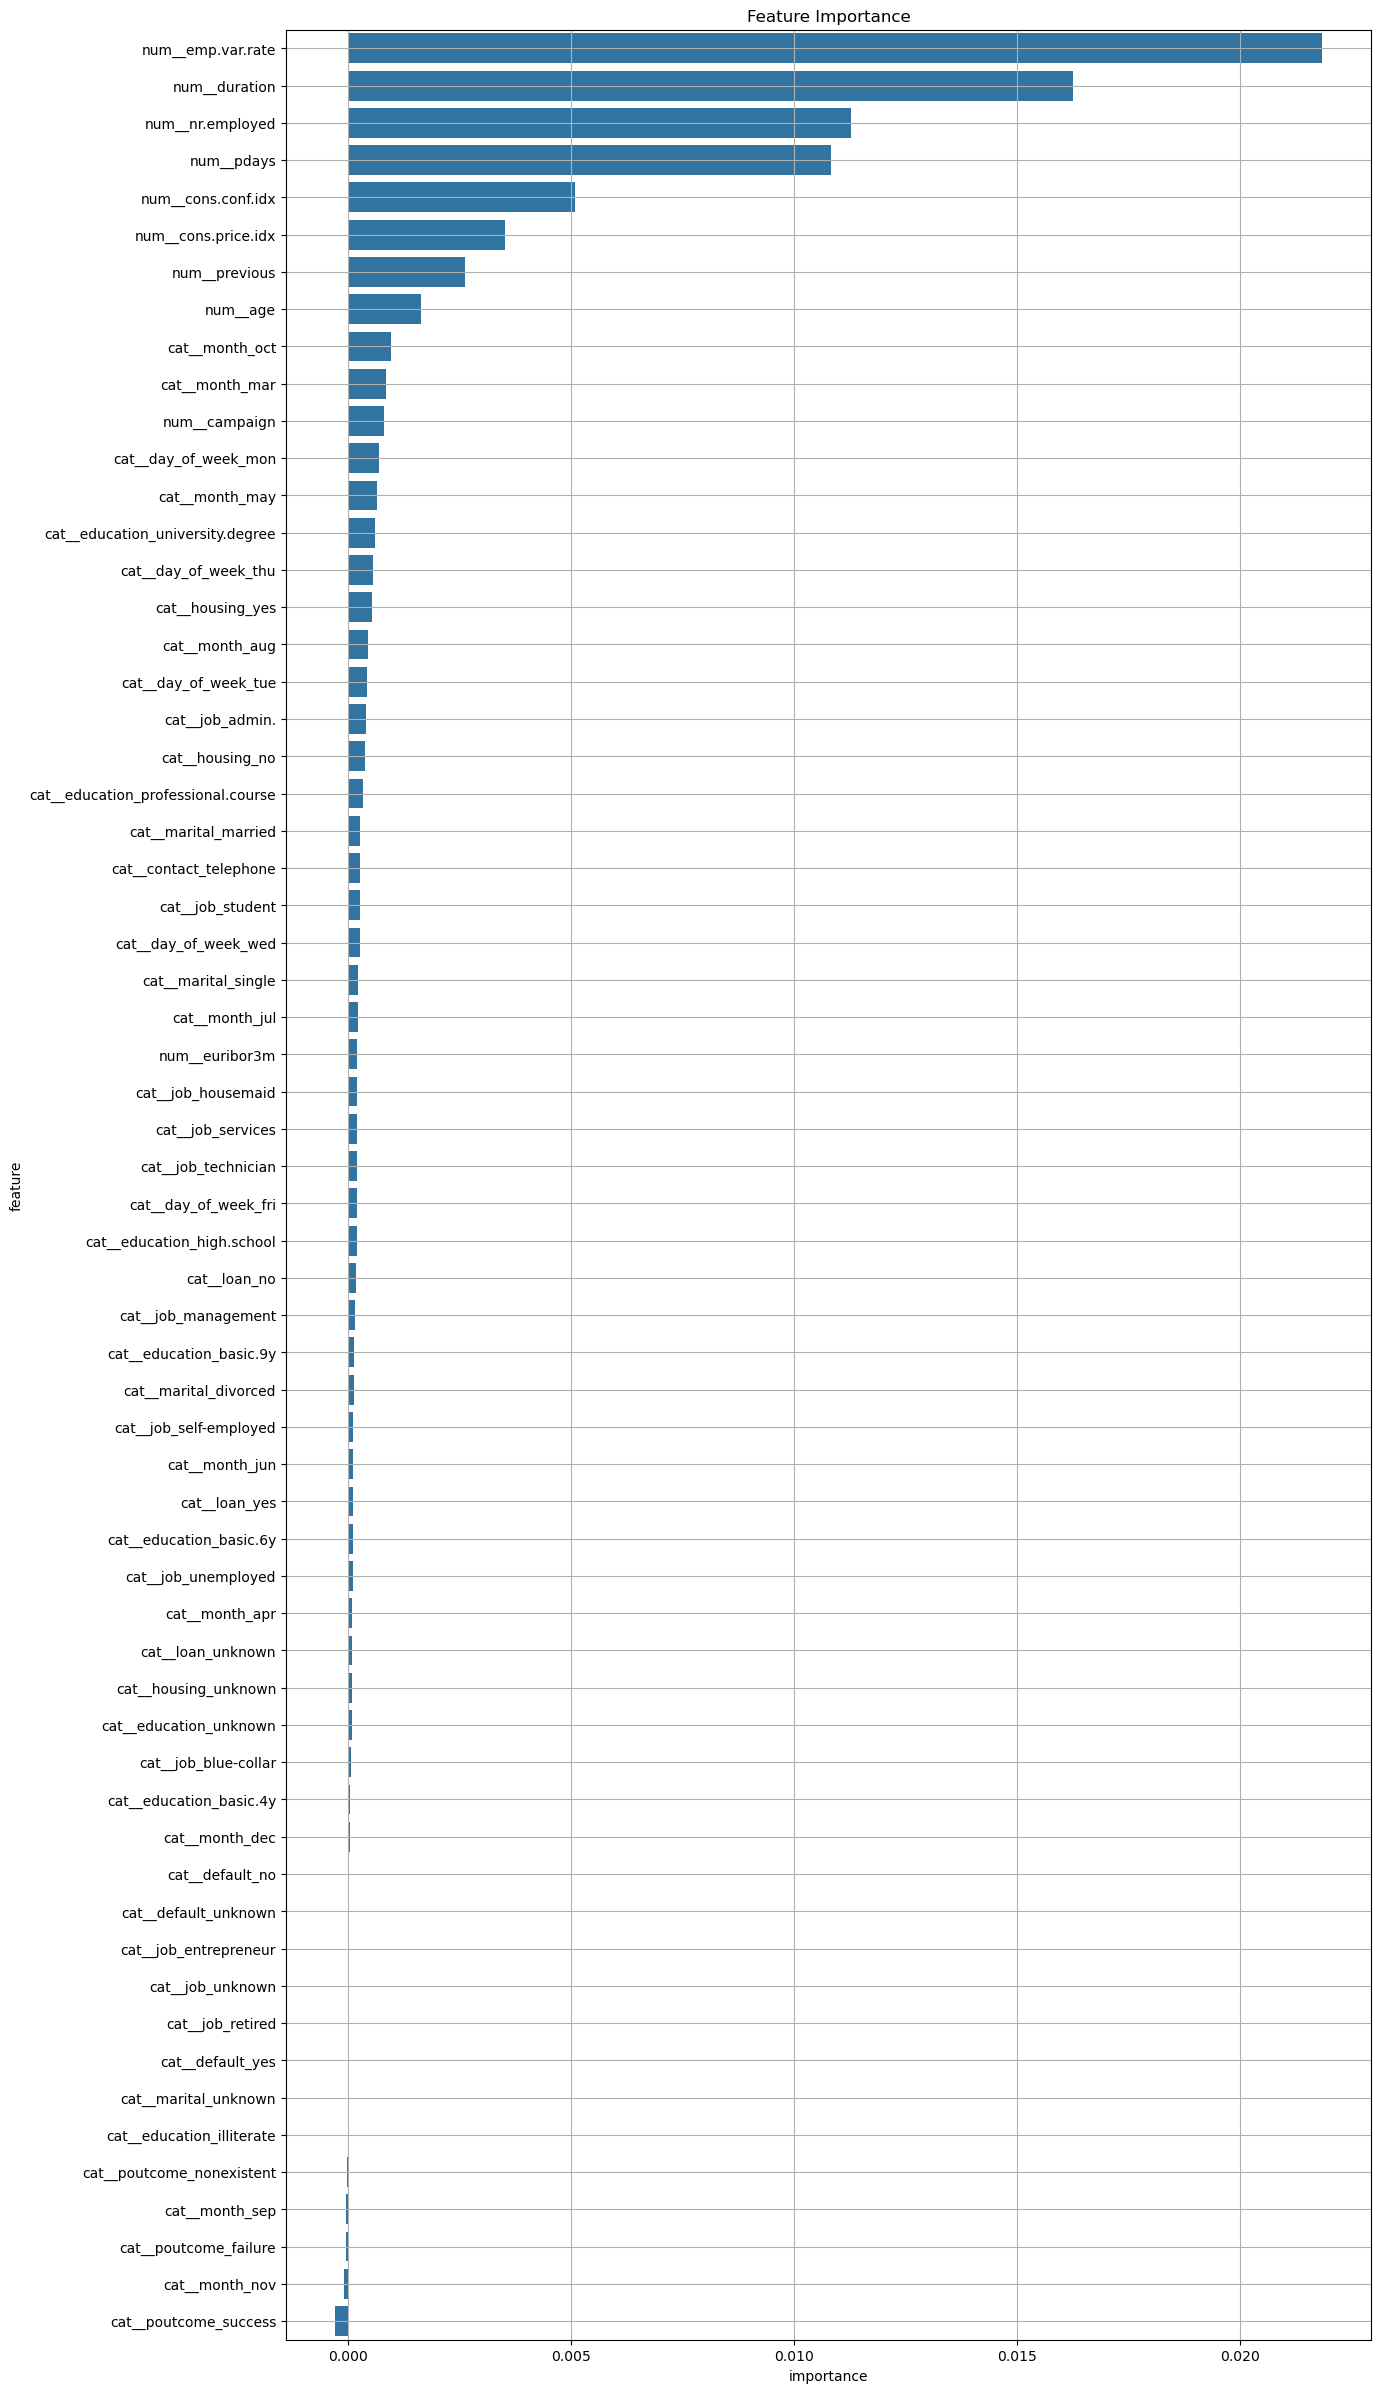

In [33]:
best_model = svm.SVC().fit(X_filtered_train, y_filtered_train)

pi = permutation_importance(
    best_model,
    X_filtered_train,
    y_filtered_train,
    n_jobs=-1,
    n_repeats=2,
    random_state=0
)

pi_s = pd.Series(pi.importances_mean, index=X.columns, name='importance')
pi_s = pi_s.sort_values(ascending=False)

plt.figure(figsize=(14,30))
ax = sns.barplot(x=pi_s.values, y=pi_s.index)
ax.set_title('Feature Importance')
ax.set_xlabel('importance')
ax.set_ylabel('feature')
plt.grid()
plt.show()